## Import my R9 contact data

In [152]:
#import packages needed

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import adjustText as aT

# some other packages from the tutorial
import plotly.express as px
import matplotlib
%matplotlib inline

#set file paths

path_r9_input = '//Users/sophieayling/Library/CloudStorage/GoogleDrive-sophie2ayling@gmail.com/My Drive/PhD/08_Fieldwork/08_Data/R9_data/stata_input/'
path_census_input = '/Users/sophieayling/Library/CloudStorage/OneDrive-UniversityCollegeLondon/GitHub/Disease-Modelling-SSA/data/preprocessed/census/5_perc/'
path_census_output = '/Users/sophieayling/Library/CloudStorage/GoogleDrive-sophie2ayling@gmail.com/My Drive/PhD/08_Fieldwork/08_Data/R9_data/plots/starplots/'

In [153]:
r9_data=path_r9_input+"r9_ivqselect_feb2023_v3_newVars.dta"
ipums_5p=path_census_input+"ipums_5p_2012_preprocessed.dta"

In [154]:
r9 = pd.read_stata(r9_data)
r9 = r9[['hhmem_key', 'hhid', 'gender_9', 'ses_5', 'age_9',  'site_type', 'occupation', 'occ4', 'school_enrolled', 'tot_contacts_yest','all_home_yest',  'all_work_yest', 'all_school_yest', 'all_com_yest', 'all_trans_yest', 'all_ent_yest', 'work_bubble', 'school_bubble', 'comm_bubble', 'transit_bubble']]
# 

In [155]:
varnames=r9.columns.tolist()
print(varnames)
#I am using the variables 

['hhmem_key', 'hhid', 'gender_9', 'ses_5', 'age_9', 'site_type', 'occupation', 'occ4', 'school_enrolled', 'tot_contacts_yest', 'all_home_yest', 'all_work_yest', 'all_school_yest', 'all_com_yest', 'all_trans_yest', 'all_ent_yest', 'work_bubble', 'school_bubble', 'comm_bubble', 'transit_bubble']


The dataset contains 9,419 observations and I am keeping the socio-economic characteristics of each as predictors, and the outcome variables for the (a) contact numbers overall and by location and (b) bubble sizes for each place outside of the home 

Our objective is to train and test a model using scikit learn that will 

A. For the contact numbers: 

(1) (done prior in stata) calculate the proportion of contacts that each person has in each location in the r9 data
(2) predict the number of contacts that each individual has, overall
(3) divide the contacts based on the proportions predicted? 
(4) apply those predictions to the census data 

B. For the bubble sizes: 

(1) (done prior in stata) calculate the distributions of the bubble sizes by occupation
(2) allocate each individual with their number of contacts to a bubble size using a random draw, but on the condition that the size of the bubble CANNOT be smaller than the number of contacts generated in A. 
(3) for each bubble draw, allocate to a bubble ID (for each non-home location) e.g. work, transport etc. 
(4) once the bubble slots are full, then move to create a new bubble ID 

NOTE: With regards to overlapping bubbles, this will happen but is not a problem because the bubble IDs are just different columns in the dataset. 


Let's check the data type for each column.

In [156]:
r9.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9418 entries, 0 to 9417
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   hhmem_key          9418 non-null   object  
 1   hhid               9418 non-null   object  
 2   gender_9           9418 non-null   category
 3   ses_5              9358 non-null   category
 4   age_9              9418 non-null   int16   
 5   site_type          9418 non-null   category
 6   occupation         9418 non-null   category
 7   occ4               9418 non-null   category
 8   school_enrolled    7778 non-null   category
 9   tot_contacts_yest  9190 non-null   float32 
 10  all_home_yest      8966 non-null   float32 
 11  all_work_yest      1806 non-null   float32 
 12  all_school_yest    721 non-null    float32 
 13  all_com_yest       2348 non-null   float32 
 14  all_trans_yest     821 non-null    float32 
 15  all_ent_yest       198 non-null    float32 
 16  work_b

In [157]:
r9.describe()

,age_9,tot_contacts_yest,all_home_yest,all_work_yest,all_school_yest,all_com_yest,all_trans_yest,all_ent_yest,work_bubble,school_bubble,comm_bubble,transit_bubble
count,9418.000000,9190.000000,8966.000000,1806.000000,721.000000,2348.000000,821.000000,198.000000,6664.000000,1112.000000,9417.000000,9418.000000
mean,37.333086,14.262786,4.288311,18.620155,19.413315,15.437819,7.842875,13.787879,11.006753,47.425360,58.895190,17.501805
std,17.159943,28.653769,2.925010,30.285707,23.876152,37.427639,10.284060,19.777582,40.319553,52.099502,95.449931,19.069315
min,15.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,22.000000,4.000000,3.000000,5.000000,5.000000,4.000000,3.000000,3.000000,0.000000,30.750000,15.000000,6.000000
50%,35.000000,6.000000,4.000000,9.000000,10.000000,6.000000,5.000000,7.000000,2.000000,42.000000,30.000000,12.000000
75%,48.000000,14.000000,5.000000,20.000000,25.000000,15.000000,8.000000,15.000000,8.000000,50.000000,60.000000,18.000000
max,101.000000,803.000000,100.000000,400.000000,200.000000,800.000000,88.000000,150.000000,1400.000000,1000.000000,2000.000000,500.000000


Almost all the data seems to be substantially skewed. Values of maxes seem okay.

Let's save our work before continuing.

## Exploratory Analysis and Visualization

Let's explore the data by visualizing the distribution of values in some columns of the dataset, and the relationships between "charges" and other columns.

We'll use libraries Matplotlib, Seaborn and Plotly for visualization. Follow these tutorials to learn how to use these libraries: 

- https://jovian.ai/aakashns/python-matplotlib-data-visualization
- https://jovian.ai/aakashns/interactive-visualization-plotly
- https://jovian.ai/aakashns/dataviz-cheatsheet

The following settings will improve the default style and font sizes for our charts.

In [158]:
sns.set_style('darkgrid')
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['figure.figsize'] = (10, 6)
matplotlib.rcParams['figure.facecolor'] = '#00000000'

### Age

Age is a numeric column. The minimum age in the dataset is 18 and the maximum age is 64. Thus, we can visualize the distribution of age using a histogram with 47 bins (one for each year) and a box plot. We'll use plotly to make the chart interactive, but you can create similar charts using Seaborn.

In [159]:
fig = px.histogram(r9, 
                   x='age_9', 
                   marginal='box', 
                   nbins=47, 
                   title='Distribution of Age')
fig.update_layout(bargap=0.1)
fig.show()

The majority of the population are between 20 and 50 years old. Largest number aged 18-19 and fewer over 50


### Contacts and Bubbles 

Let's visualize the distribution of contacts and bubble sizes. These are the column we're trying to predict. Let's also use the categorical column male/female to see how this is different for the two

In [160]:
fig = px.histogram(r9, 
                   x='all_work_yest', 
                   marginal='box', 
                   color='gender_9', 
                   color_discrete_sequence=['green', 'blue'], 
                   title='Contacts yesterday by gender'
                  )

fig.update_xaxes(range=[0,100])
fig.update_layout(bargap=0.1)
fig.show()

In [161]:
fig = px.histogram(r9, 
                   x='work_bubble', 
                   marginal='box', 
                   color='gender_9', 
                   color_discrete_sequence=['green', 'blue'], 
                   title='Bubble size yesterday by gender'
                  )

fig.update_xaxes(range=[0,100])
fig.update_layout(bargap=0.1)
fig.show()

In [162]:
# now plot the work contacts and bubbles on top of eachother 
fig = px.histogram(r9, 
                   x=['all_work_yest', 'work_bubble'], 
                   marginal='box', 
                   #color='gender_9', 
                   #color_discrete_sequence=['green', 'blue'], 
                   title='Contacts in Bubbles at Work Yest'
                  )

fig.update_xaxes(range=[0,100])
fig.update_layout(bargap=0.1)
fig.show()

### Contacts and Bubble sizes 

Let's visualize the relationship between contacts and bubble sizes using site type as the colour

In [163]:
fig = px.scatter(r9, 
                 x='all_work_yest', 
                 y='work_bubble', 
                 color='site_type', 
                 opacity=0.8, 
                 hover_data=['site_type'], 
                 title='contacts vs. bubbles')
fig.update_xaxes(range=[0,200])
fig.update_traces(marker_size=5)
fig.show()

# there are some people who have work bubbles reported that are smaller than the number of contacts they reported at work yesterday

For those people who have bigger bubbles than contact numbers, they will probably end up creating erroneous predictions, so better to not include those in the training data. 

### Correlation

As you can tell from the analysis, the values in some columns are more closely related to the values in "charges" compared to other columns. E.g. "age" and "charges" seem to grow together, whereas "bmi" and "charges" don't.

This relationship is often expressed numerically using a measure called the _correlation coefficient_, which can be computed using the `.corr` method of a Pandas series.

In [164]:
r9.all_work_yest.corr(r9.age_9)

0.03564142289367283

In [165]:
r9.all_work_yest.corr(r9.work_bubble)

0.3525629804306572

To compute the correlation for categorical columns, they must first be converted into numeric columns.

In [166]:
r9['gender_vals'] = pd.factorize(r9['gender_9'])[0]
r9.all_work_yest.corr(r9.gender_vals)

-0.06478968103428205

Let's save our work before continuing.

## Linear Regression using a Single Feature

We now know that the "smoker" and "age" columns have the strongest correlation with "charges". Let's try to find a way of estimating the value of "charges" using the value of "age" for non-smokers. First, let's create a data frame containing just the data for non-smokers.

Next, let's visualize the relationship between "age" and "charges"

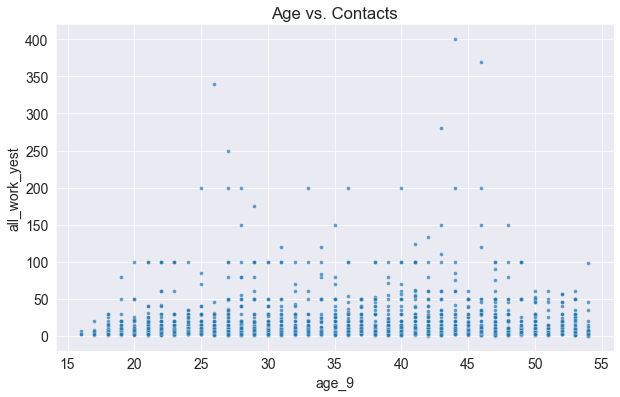

In [167]:
plt.title('Age vs. Contacts')
sns.scatterplot(data=r9, x='age_9', y='all_work_yest', alpha=0.7, s=15);

Apart from a few exceptions, the points seem to form a line. We'll try and "fit" a line using this points, and use the line to predict charges for a given age. A line on the X&Y coordinates has the following formula:

$y = wx + b$

The line is characterized two numbers: $w$ (called "slope") and $b$ (called "intercept"). 

### Model

In the above case, the x axis shows "age" and the y axis shows "charges". Thus, we're assuming the following relationship between the two:

$charges = w \times age + b$

We'll try determine $w$ and $b$ for the line that best fits the data. 

* This technique is called _linear regression_, and we call the above equation a _linear regression model_, because it models the relationship between "age" and "charges" as a straight line. 

* The numbers $w$ and $b$ are called the _parameters_ or _weights_ of the model.

* The values in the "age" column of the dataset are called the _inputs_ to the model and the values in the charges column are called "targets". 

Let define a helper function `estimate_charges`, to compute $charges$, given $age$, $w$ and $b$.


In [168]:
def estimate_contacts(age, w, b):
    return w * age + b

The `estimate_charges` function is our very first _model_.

Let's _guess_ the values for $w$ and $b$ and use them to estimate the value for charges.

In [169]:
w = 50
b = 60

In [170]:
# defining an array version of ages so it can be used in the function 
age = r9['age_9'].values


In [171]:
estimate_contacts_t = estimate_contacts(age, w, b)
print(estimate_contacts_t)
# this is already an array because I'm passing it an array of values (as per .values above)

[3460  810 3060 ... 1810 3310 1760]


We can plot the estimated contacts using a line graph.

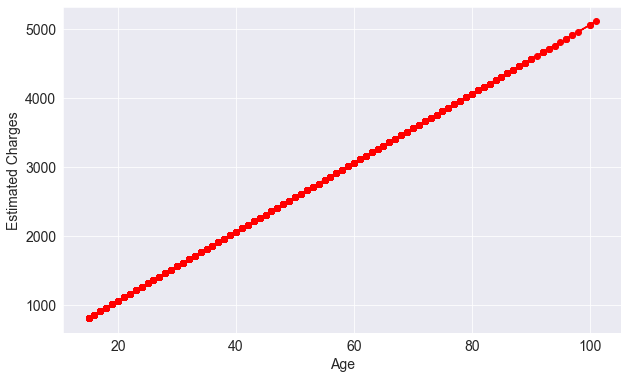

In [172]:
plt.plot(age, estimate_contacts_t, 'r-o');
plt.xlabel('Age');
plt.ylabel('Estimated Charges');

As expected, the points lie on a straight line. 

We can overlay this line on the actual data, so see how well our _model_ fits the _data_.

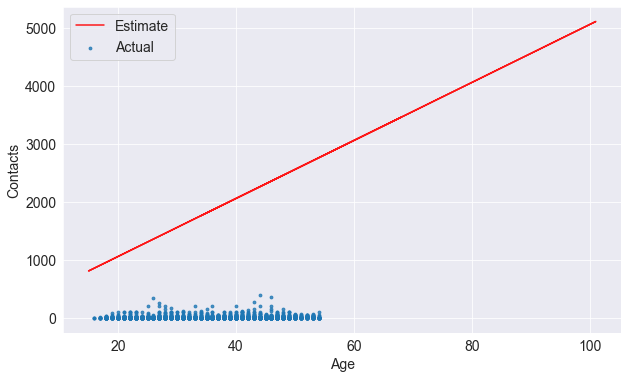

In [173]:
target = r9.all_work_yest.values

plt.plot(age, estimate_contacts_t, 'r', alpha=0.9);
plt.scatter(age, target, s=8,alpha=0.8);
plt.xlabel('Age');
plt.ylabel('Contacts')
plt.legend(['Estimate', 'Actual']);

Clearly, the our estimates are quite poor and the line does not "fit" the data. However, we can try different values of $w$ and $b$ to move the line around. Let's define a helper function `try_parameters` which takes `w` and `b` as inputs and creates the above plot.

In [174]:
def try_parameters(w, b):
    age = r9.age_9.values
    target = r9.all_work_yest
    # here I'm explicitly showing that I'm using the array version of each of these variables rather than their dataframe indexed versions
    
    estimate_contacts_t = estimate_contacts(age, w, b)
    
    plt.plot(age, estimate_contacts_t, 'r', alpha=0.9);
    plt.scatter(age, target, s=8,alpha=0.8);
    plt.xlabel('Age');
    plt.ylabel('Contacts')
    plt.legend(['Estimate', 'Actual']);

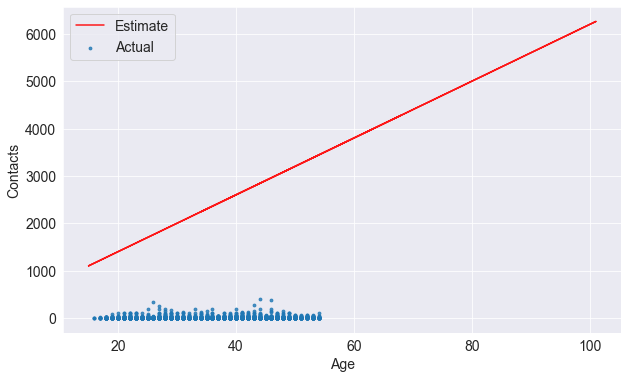

In [175]:
try_parameters(60, 200)

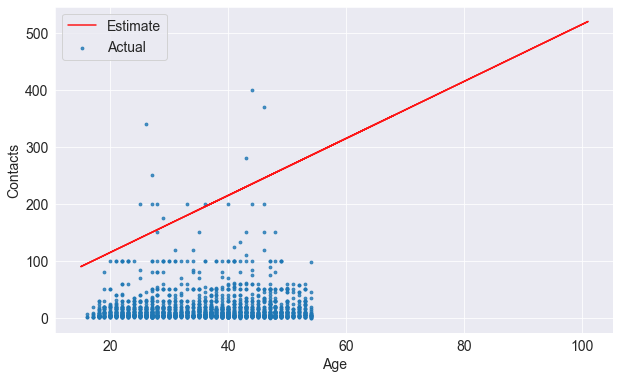

In [176]:
try_parameters(5, 15)

In [177]:
def rmse(targets, predictions):
    return np.sqrt(np.mean(np.square(targets - predictions)))

Let's compute the RMSE for our model with a sample set of weights

In [178]:
w = 50
b = 100

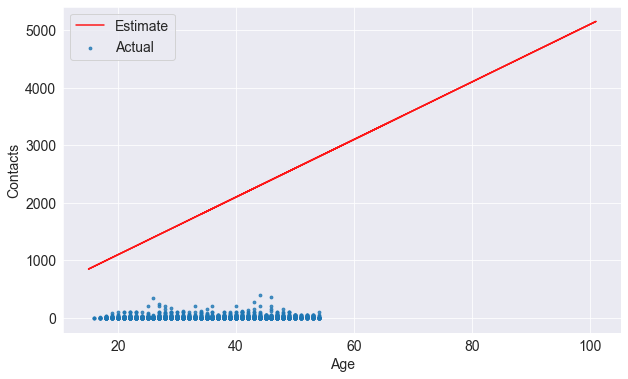

In [179]:
try_parameters(w, b)

In [180]:
targets = r9['all_work_yest']  # here it didn't need me to put the array (in fact doesn't work if I do)
predicted = estimate_contacts(age, w, b)
print(predicted)

[3500  850 3100 ... 1850 3350 1800]


In [181]:
rmse(targets, predicted)

1942.3656

Here's how we can interpret the above number: *On average, each element in the prediction differs from the actual target by 1,942 contacts! 

The result is called the *loss* because it indicates how bad the model is at predicting the target variables. It represents information loss in the model: the lower the loss, the better the model.

Let's modify the `try_parameters` functions to also display the loss.

In [182]:

def try_parameters(w, b):
    age = r9.age_9.values
    target = r9.all_work_yest #again, don't specify array for target 
       
    predictions = estimate_contacts(age, w, b)
    
    plt.plot(age, predictions, 'r', alpha=0.9);
    plt.scatter(age, target, s=8,alpha=0.8);
    plt.xlabel('Age');
    plt.ylabel('Contacts')
    plt.legend(['Prediction', 'Actual']);
    
    loss = rmse(target, predictions) # this is the added piece
    print("RMSE Loss: ", loss)

RMSE Loss:  171.8382


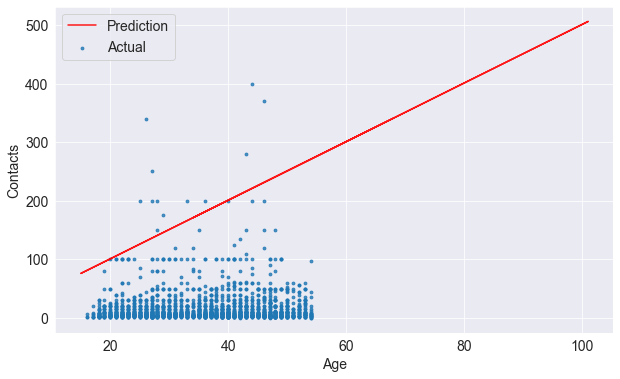

In [183]:
try_parameters(5, 1) # shows great improvement! Though still sooooo off. 

> **EXERCISE**: Try different values of $w$ and $b$ to minimize the RMSE loss. What's the lowest value of loss you are able to achieve? Can you come with a general strategy for finding better values of $w$ and $b$ by trial and error?

### Optimizer

Next, we need a strategy to modify weights `w` and `b` to reduce the loss and improve the "fit" of the line to the data.

* Ordinary Least Squares: https://www.youtube.com/watch?v=szXbuO3bVRk (better for smaller datasets)
* Stochastic gradient descent: https://www.youtube.com/watch?v=sDv4f4s2SB8 (better for larger datasets)

Both of these have the same objective: to minimize the loss, however, while ordinary least squares directly computes the best values for `w` and `b` using matrix operations, while gradient descent uses a iterative approach, starting with a random values of `w` and `b` and slowly improving them using derivatives. 

Here's a visualization of how gradient descent works:

![](https://miro.medium.com/max/1728/1*NO-YvpHHadk5lLxtg4Gfrw.gif)

Doesn't it look similar to our own strategy of gradually moving the line closer to the points?



### Linear Regression using Scikit-learn

In practice, you'll never need to implement either of the above methods yourself. You can use a library like `scikit-learn` to do this for you. 

Let's use the `LinearRegression` class from `scikit-learn` to find the best fit line for "age" vs. "charges" using the ordinary least squares optimization technique.

In [184]:
from sklearn.linear_model import LinearRegression

First, we create a new model object.

In [185]:
model = LinearRegression()

Next, we can use the `fit` method of the model to find the best fit line for the inputs and targets.

In [186]:
help(model.fit)

Help on method fit in module sklearn.linear_model._base:

fit(X, y, sample_weight=None) method of sklearn.linear_model._base.LinearRegression instance
    Fit linear model.
    
    Parameters
    ----------
    X : {array-like, sparse matrix} of shape (n_samples, n_features)
        Training data.
    
    y : array-like of shape (n_samples,) or (n_samples, n_targets)
        Target values. Will be cast to X's dtype if necessary.
    
    sample_weight : array-like of shape (n_samples,), default=None
        Individual weights for each sample.
    
        .. versionadded:: 0.17
           parameter *sample_weight* support to LinearRegression.
    
    Returns
    -------
    self : object
        Fitted Estimator.



Not that the input `X` must be a 2-d array, so we'll need to pass a dataframe, instead of a single column.

In [187]:
#clean up the variables before putting them in the model
r9_filtered=r9[r9['all_work_yest'].notnull()]

#input to model 
inputs = r9_filtered[['age_9']]
targets = r9_filtered['all_work_yest']
print('inputs.shape :', inputs.shape)
print('targets.shape :', targets.shape) # note that we have very few observations here 


inputs.shape : (1806, 1)
targets.shape : (1806,)


Let's fit the model to the data.

In [188]:
model.fit(inputs, targets)

LinearRegression()

We can now make predictions using the model. Let's try predicting the contacts for the ages 23, 37 and 61

In [189]:
model.predict(np.array([[23], 
                        [37], 
                        [61]]))

/opt/anaconda3/envs/covid19_abm/lib/python3.8/site-packages/sklearn/base.py:465: UserWarning:

X does not have valid feature names, but LinearRegression was fitted with feature names



array([17.21519922, 18.73645754, 21.34432893])

Do these values seem reasonable? Compare them with the scatter plot above.

Let compute the predictions for the entire set of inputs

In [190]:
predictions = model.predict(inputs)
pred_contacts=predictions.reshape(-1, 1)


In [191]:
r9_filtered['pred_contacts']= pred_contacts
r9_filtered[['tot_contacts_yest', 'pred_contacts']].head(10)

<ipython-input-191-d9f18b175498>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,tot_contacts_yest,pred_contacts
7,8.0,20.149055
9,13.0,18.301812
18,8.0,19.931732
22,22.0,17.975828
24,12.0,19.279764
25,10.0,19.279764
30,256.0,17.867167
31,12.0,17.649844
33,10.0,18.193151
34,12.0,17.541183


Let's compute the RMSE loss to evaluate the model.

In [192]:
rmse(targets, predictions)

30.25808434529401

Seems like our prediction is off by 30 contacts on average, which is not great!

The parameters of the model are stored in the `coef_` and `intercept_` properties.

In [193]:
# w
model.coef_

array([0.10866131])

In [194]:
# b
model.intercept_

14.715989141484116

Are these parameters close to your best guesses?

Let's visualize the line created by the above parameters.

RMSE Loss:  30.25808434529401


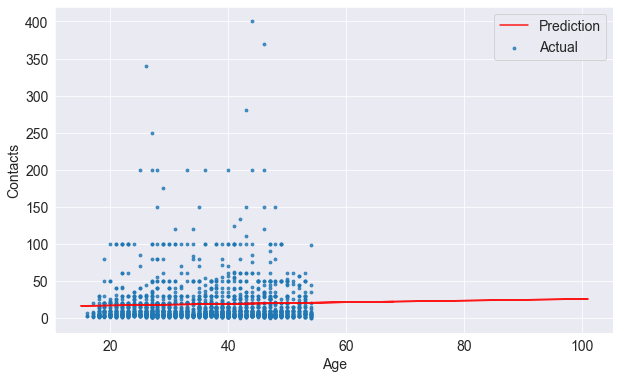

In [195]:
try_parameters(model.coef_, model.intercept_)

Indeed the line is quite close to the points. It is slightly above the cluster of points, because it's also trying to account for the outliers. 

# SGD Regressor using multiple input features (variables) i.e. multivariate regression

> **EXERCISE**: Use the [`SGDRegressor`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDRegressor.html) class from `scikit-learn` to train a model using the stochastic gradient descent technique. Make predictions and compute the loss. Do you see any difference in the result?

In [196]:
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error


> **EXERCISE**: Repeat the steps is this section to train a linear regression model for predictors of contacts. Visualize the targets and predictions, and compute the loss.

In [197]:
#covariates
X= r9_filtered[['gender_9', 'ses_5', 'age_9', 'site_type', 'occ4', 'school_enrolled']]

# convert the categorical variables to dummies using one-hot encoding 
r9_filtered_numeric = pd.get_dummies(X)

# check out the new dataframe 
#r9_filtered_numeric.info()

# dependent variable needs to be converted to a 1D array 
y_array= np.array(r9_filtered[['all_work_yest']]) # this must be the same as doing all_work_yest.values
y= y_array.ravel()
print(y)

y=r9_filtered.all_work_yest.values


[ 2. 10.  2. ... 10. 20.  2.]


In [198]:
# drop the reference categories from the DF (as per Huanfa's tutorial https://github.com/huanfachen/DSSS/blob/main/Week_2/Practical-02_SOLUTION.ipynb)

columns_to_drop = [1, 3, 8, 22, 28]
r9_final_ML= r9_filtered

# check final result 
#r9_final_ML.info()

# reassign X covariates
X= r9_final_ML


In [199]:
# Create inputs and targets
inputs, targets = X, y

# Create and train the model
model = LinearRegression().fit(inputs, targets)

# Generate predictions
predictions = model.predict(inputs)

# Compute loss to evalute the model
loss = rmse(targets, predictions)
print('Loss:', loss)

# This version results in a loss of 28, so not a great amount better than the previous


ValueError: Input contains NaN

In [ ]:
# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Initialize the SGDRegressor
sgd_regressor = SGDRegressor(max_iter=1000, tol=1e-3, random_state=42)

In [ ]:
# Train/Fit the model
sgd_regressor.fit(X_train, y_train)


In [ ]:
# # Now examine the results 
# r9_filtered['sgd_contacts']= sgd_regressor.predict
# r9_filtered['pred_contacts']= pred_contacts
# r9_filtered[['tot_contacts_yest', 'pred_contacts', 'sgd_contacts']].head(10)

pred_contacts

# can't figure out how to see the results???

## Summary and Further Reading

We've covered the following topics in this tutorial:

- A typical problem statement for machine learning
- Downloading and exploring a dataset for machine learning
- Linear regression with one variable using Scikit-learn
- Linear regression with multiple variables 
- Using categorical features for machine learning
- Regression coefficients and feature importance
- Creating a training and test set for reporting results

Apply the techniques covered in this tutorial to the following datasets:

- https://www.kaggle.com/vikrishnan/boston-house-prices
- https://www.kaggle.com/sohier/calcofi
- https://www.kaggle.com/budincsevity/szeged-weather 


Check out the following links to learn more about linear regression:

- https://jovian.ai/aakashns/02-linear-regression
- https://www.kaggle.com/hely333/eda-regression
- https://www.youtube.com/watch?v=kHwlB_j7Hkc

